In [1]:

import numpy as np 
import pandas as pd

import cv2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense
from tensorflow.keras.preprocessing.image import load_img, img_to_array, array_to_img, ImageDataGenerator 
from PIL import Image 
from glob import glob
import pprint



import os
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras import layers
from tensorflow.keras import Model

from tensorflow.keras.applications.resnet import ResNet50, ResNet101
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.optimizers import Adam, Nadam
import pathlib
from tensorflow.keras.applications.xception import preprocess_input
from tensorflow.keras.applications.xception import decode_predictions

for dirname, _, filenames in os.walk('./datas/fruits-360/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [2]:
#train_path = pathlib.Path('./datas/fruits-360/Training/')
#test_path = pathlib.Path('./datas/fruits-360/Test/')

train_path = pathlib.Path('../datas/fruits2/Training/')
test_path = pathlib.Path('../datas/fruits2/Test/')

#train_path = ('./drive/MyDrive/fruits-360-mini/train/')
#test_path = ('./drive/MyDrive/fruits-360-mini/test/')

In [3]:
subs_train_label = [x.split('/')[-1] for x in os.listdir(train_path)]
subs_test_label = [x.split('/')[-1] for x in os.listdir(test_path)]
#subs_train = [x[0] for x in os.walk(train_path)]
#subs_test = [x[0] for x in os.walk(test_path)]


In [4]:
subs_test_label

['Quince',
 'Watermelon',
 'Tomato Heart',
 'Walnut',
 'Potato White',
 'Tomato Maroon',
 'Tomato Cherry Red',
 'Tomato Yellow',
 'Tomato not Ripened']

In [5]:
subs_train_labels = list(filter(None, subs_train_label))
subs_test_labels = list(filter(None, subs_test_label))
#subs_train_paths = list(filter(None, subs_train))[1:]
#subs_test_paths = list(filter(None, subs_test))[1:]


print(len(subs_train_labels))
print(len(subs_test_labels))
#print(len(subs_train_paths))
#print(len(subs_test_paths))
print(set(subs_train_label) == set(subs_test_label))

9
9
True


In [6]:
labels = sorted(subs_train_labels)

In [7]:
labels[0]

'Potato White'

In [8]:
#x = load_img(str(train_path) + '/' + labels[0] + "/10_100.jpg")
#x = load_img(str(train_path) + '/' + labels[0] + "/image_0.jpg")
x = load_img(str(train_path) + '/' + labels[0] + "/18_100.jpg")
img_shape = img_to_array(x).shape
img_shape = [224,224,3]
print(img_shape)

[224, 224, 3]


In [9]:
#fig = plt.figure(figsize =(15,8))
#for i in range(25):
#    ax = fig.add_subplot(5,5,i+1,xticks=[],yticks=[])
#    plt.axis("off")
#    plt.title(labels[i])
#    ax.imshow(load_img(str(train_path) + '/' + labels[i] +"/10_100.jpg"))

In [10]:
pre_trained_model = ResNet101(input_shape = img_shape, 
                                include_top = False, # without FC
                                weights = 'imagenet')

In [11]:
for layer in pre_trained_model.layers:
    layer.trainable = False

In [12]:
class myCallback(Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy')>0.99):
            print("\nReached 95% accuracy so cancelling training!")
            self.model.stop_training = True

In [13]:
#tf.keras.backend.clear_session()



# Prepare for FC connexion
#model = Sequential([pre_trained_model, 
#            layers.GlobalAveragePooling2D(),
#            layers.Dropout(rate=0.5),
#            layers.Dense(1024),
#            layers.Dropout(rate=0.5),
#            layers.Dense(5),
#            layers.Softmax()])

model = Sequential([
    pre_trained_model,
    layers.Flatten(),
    layers.Dense(1024, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(len(labels), activation="softmax")
])




model.compile(optimizer = Adam(lr=0.001), 
              loss = tf.keras.losses.CategoricalCrossentropy(), 
              metrics = ['accuracy'])



In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet101 (Model)            (None, 7, 7, 2048)        42658176  
_________________________________________________________________
flatten (Flatten)            (None, 100352)            0         
_________________________________________________________________
dense (Dense)                (None, 1024)              102761472 
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 9)                 9225      
Total params: 145,428,873
Trainable params: 102,770,697
Non-trainable params: 42,658,176
_________________________________________________________________


In [15]:
img_shape[:2]

[224, 224]

In [16]:
train_datagen = ImageDataGenerator(rescale = 1./255.)

test_datagen = ImageDataGenerator( rescale = 1.0/255.)

train_generator = train_datagen.flow_from_directory(train_path,
                                                    batch_size = 32,
                                                    class_mode  = 'categorical',
                                                    target_size = img_shape[:2])   

validation_generator =  test_datagen.flow_from_directory( test_path,
                                                          batch_size  = 32,
                                                          class_mode  = 'categorical',
                                                          target_size = img_shape[:2])

Found 4626 images belonging to 9 classes.
Found 1552 images belonging to 9 classes.


In [17]:
callbacks = myCallback()
history = model.fit_generator(
            train_generator,
            validation_data = validation_generator,
            steps_per_epoch = 1500//32,
            epochs = 50,
            validation_steps = 500//32,
            verbose = 2,
            callbacks=[callbacks])


Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/50
46/46 - 201s - loss: 7.5130 - accuracy: 0.3930 - val_loss: 0.7824 - val_accuracy: 0.7958
Epoch 2/50
46/46 - 196s - loss: 0.5758 - accuracy: 0.8200 - val_loss: 0.4201 - val_accuracy: 0.8896
Epoch 3/50
46/46 - 199s - loss: 0.3572 - accuracy: 0.9062 - val_loss: 0.3843 - val_accuracy: 0.9000
Epoch 4/50
46/46 - 203s - loss: 0.2447 - accuracy: 0.9429 - val_loss: 0.3054 - val_accuracy: 0.8875
Epoch 5/50
46/46 - 202s - loss: 0.1933 - accuracy: 0.9531 - val_loss: 0.3174 - val_accuracy: 0.9021
Epoch 6/50
46/46 - 199s - loss: 0.2028 - accuracy: 0.9492 - val_loss: 0.2613 - val_accuracy: 0.9187
Epoch 7/50
46/46 - 202s - loss: 0.1243 - accuracy: 0.9681 - val_loss: 0.2231 - val_accuracy: 0.9125
Epoch 8/50
46/46 - 204s - loss: 0.1031 - accuracy: 0.9769 - val_loss: 0.2294 - val_accuracy: 0.9062
Epoch 9/50
46/46 - 196s - loss: 0.0756 - accuracy: 0.9857 - val_loss: 0.2482 - val_accuracy: 0.8917
Epoch 10/50
46/46 - 200s

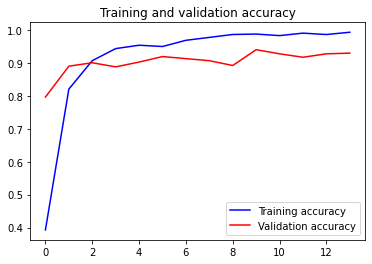

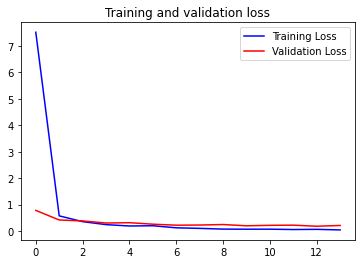

In [18]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [19]:
import pickle

with open('trainHistoryDict.txt', 'wb') as file_pi:
              pickle.dump(model.history.history, file_pi)

In [21]:
model.save('99model.h5')

99model.h5                  LICENSE           trainHistoryDict.txt
Data_preprocessing.ipynb    README.md
Fruit360_9_Resnet101.ipynb  requirements.txt
